# Modelo HoltWinters

Autor: Sergio Diaz Paredes

Contacto: [Linkedin](https://www.linkedin.com/in/sergio-diaz-paredes/)

El análisis de series temporales es una herramienta clave para comprender el comportamiento de variables a lo largo del tiempo. En este notebook se estudia una serie de datos de ventas diarias, con el objetivo de descomponerla en sus componentes fundamentales: tendencia, estacionalidad y ruido. Esta descomposición permite interpretar mejor la dinámica del negocio y facilita la toma de decisiones basadas en datos.

Como herramienta principal de pronóstico se utiliza el modelo Holt-Winters, una técnica de suavizamiento exponencial que destaca por su simplicidad y eficiencia. Este modelo es ideal para escenarios donde se busca una solución rápida y confiable, ya que permite incorporar tanto una tendencia lineal como un patrón estacional de forma flexible.

Gracias a su facilidad de implementación en Python y su capacidad para generar predicciones precisas en poco tiempo, Holt-Winters se presenta como una excelente alternativa introductoria para quienes inician en el análisis y pronóstico de series temporales.

## Paquetes

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Dataset

In [ ]:
data = pd.read_csv("analisis_serie.csv", index_col=0, parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137 entries, 2024-01-01 to 2024-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ventas  137 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [ ]:
data.head()

,ventas
2024-01-01,457.450712
2024-01-02,446.426035
2024-01-03,456.715328
2024-01-04,468.345448
2024-01-05,440.487699


## Análisis Exploratorio

In [ ]:
data.describe()

,ventas
count,137.000000
mean,446.573949
std,72.415699
min,341.634336
25%,389.861260
50%,428.048735
75%,492.981193
max,621.484310


<Axes: >

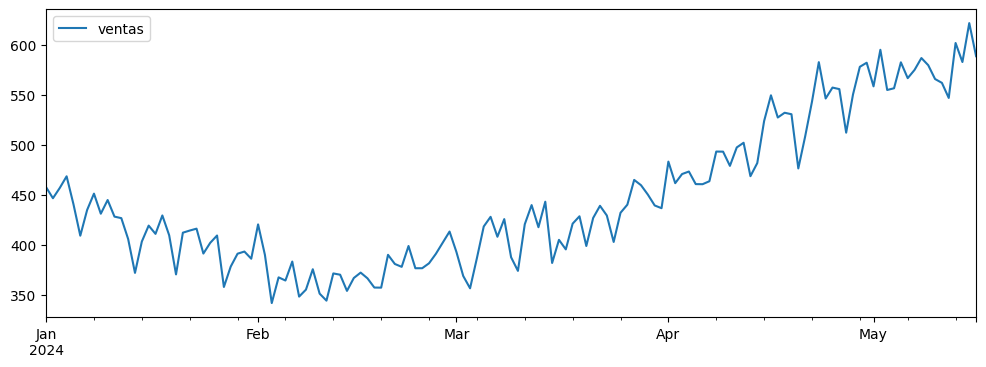

In [ ]:
data.plot(figsize=(12,4))

## Análisis de tendencia

### 🔹 **Promedio móvil (rolling mean)**

Es un método que suaviza una serie de tiempo calculando el **promedio de los últimos *n* valores**. Se usa para reducir el "ruido" y resaltar la tendencia general.

📌 *Ejemplo:* Si usamos una ventana de 10 días, cada punto es el promedio de esos 10 días anteriores.

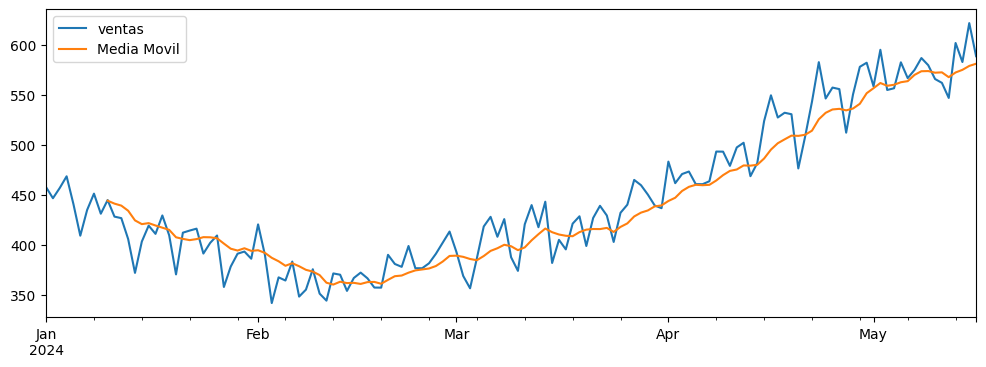

In [ ]:
data.plot(figsize=(12,4))
data.ventas.rolling(10).mean().plot(label='Media Movil')
plt.legend()
plt.show()

### 🔹 **Promedio móvil exponencial (EWMA)**

Similar al promedio móvil, pero da **más peso a los datos recientes**, lo que lo hace más sensible a cambios. Es ideal para detectar giros rápidos en la tendencia.

📌 *Ejemplo:* Con `span=4`, los valores más nuevos tienen más influencia que los antiguos.

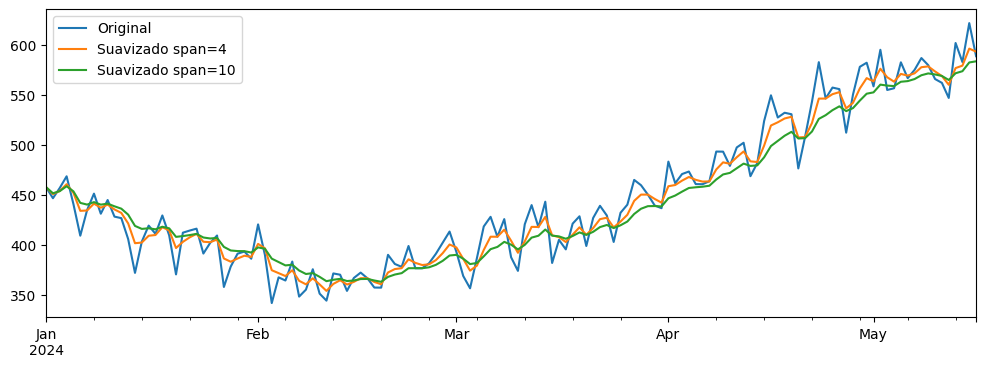

In [ ]:
data.ventas.plot(label='Original',figsize=(12,4))
data.ventas.ewm(span=4).mean().plot(label='Suavizado span=4')
data.ventas.ewm(span=10).mean().plot(label='Suavizado span=10')
plt.legend()

### 🔹 **Tendencia LOESS (o LOWESS)**

Es un **suavizado local** que ajusta pequeños modelos de regresión a partes de los datos. A diferencia de los promedios, **no asume forma lineal** y se adapta mejor a cambios no lineales.

📌 *Ventaja:* Captura bien curvas suaves o cambios graduales sin necesidad de un modelo global.

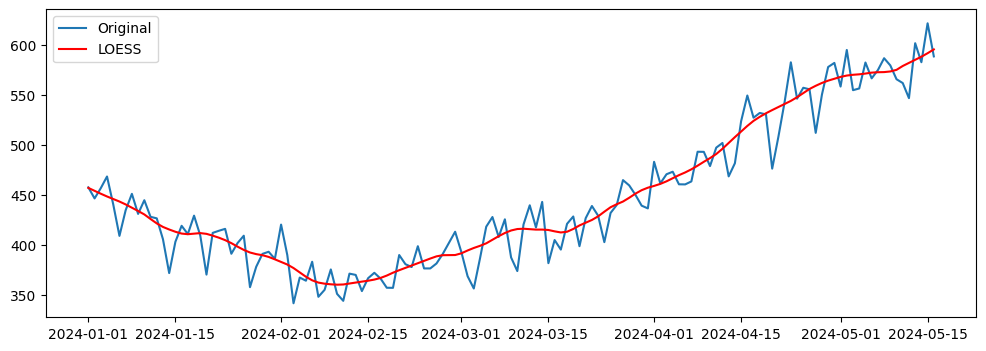

In [44]:
from statsmodels.nonparametric.smoothers_lowess import lowess

loess = lowess(data['ventas'], np.arange(len(data)), frac=0.1)
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(data.index, data['ventas'], label='Original')
plt.plot(data.index, loess[:,1], label='LOESS', color='red')
plt.legend()
plt.show()

## Análisis de estacionalidad

### Dias de la semana

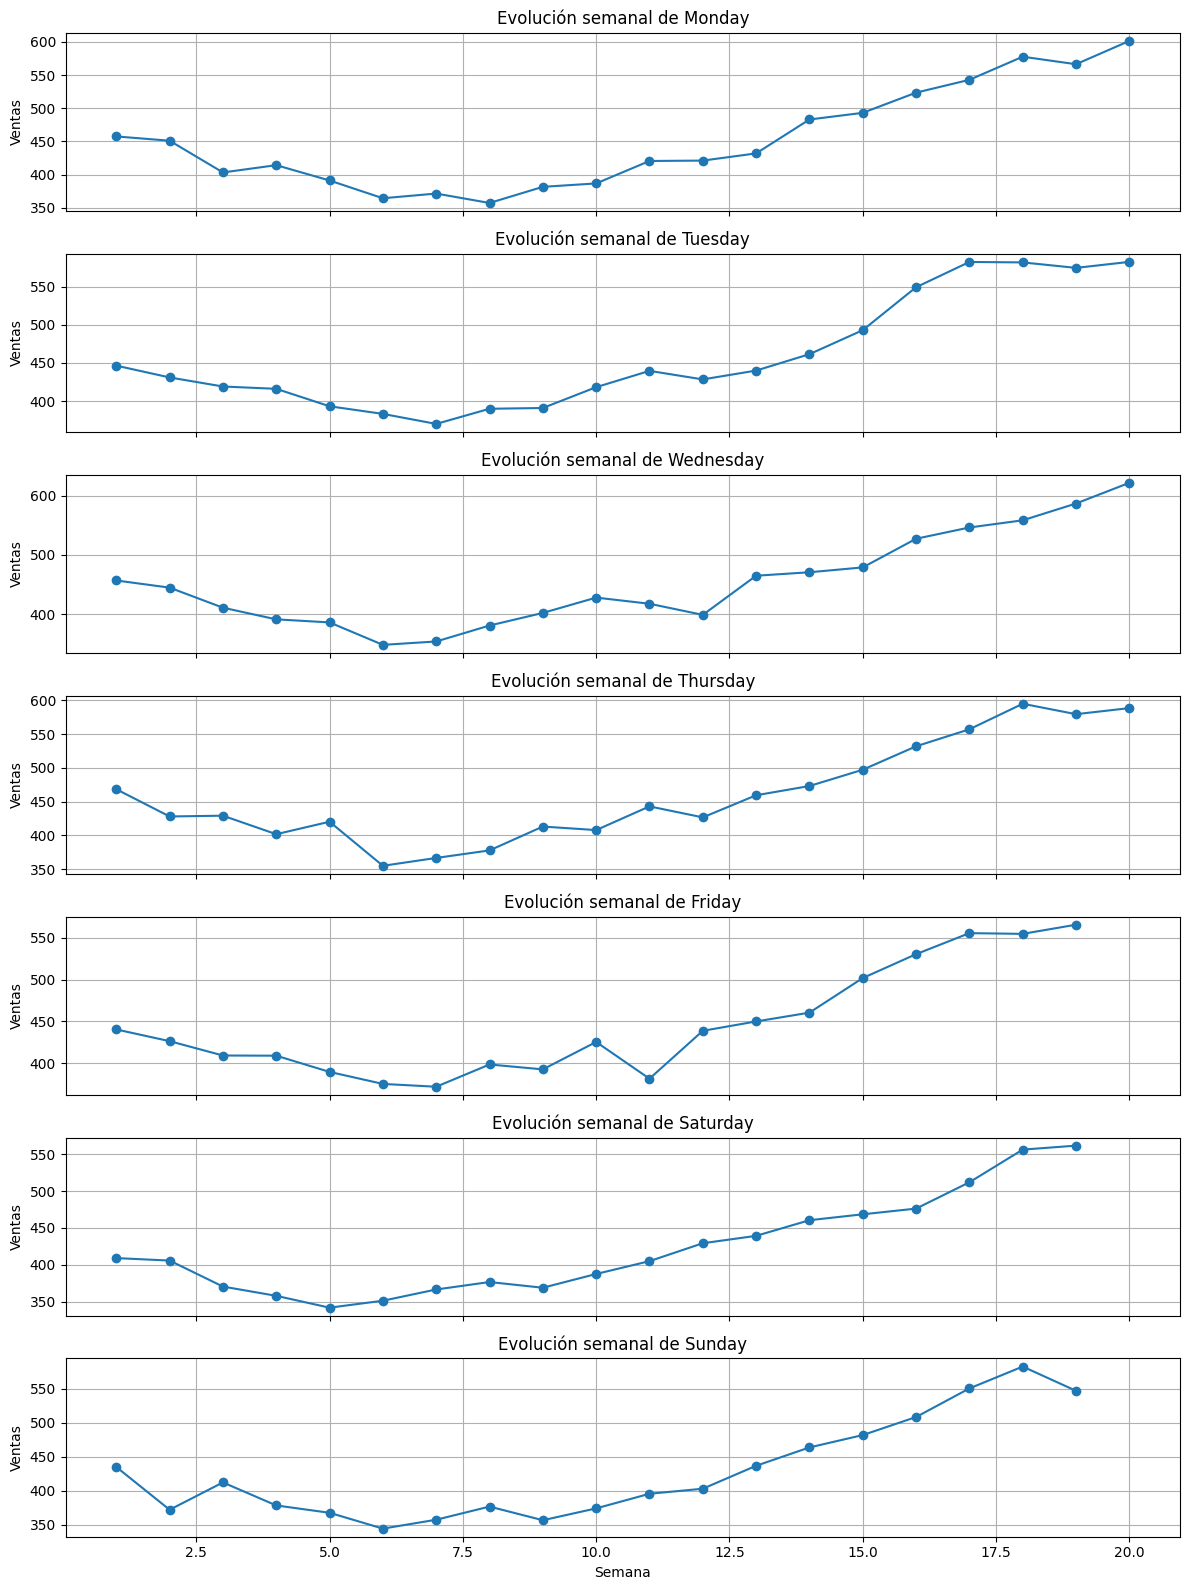

In [55]:
# Asegúrate de tener el índice como datetime
data['semana'] = data.index.isocalendar().week
data['dia_semana'] = data.index.day_name()  # Puedes usar dayofweek si prefieres en número

# Crear tabla pivote: semana vs día de semana
pivot = data.pivot_table(index='semana', columns='dia_semana', values='ventas')

# Ordenar columnas por día de la semana
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot = pivot[orden_dias]

# Graficar cada día en subplots
fig, axes = plt.subplots(7, 1, figsize=(12, 16), sharex=True)

for i, dia in enumerate(orden_dias):
    axes[i].plot(pivot.index, pivot[dia], marker='o')
    axes[i].set_title(f'Evolución semanal de {dia}')
    axes[i].set_ylabel('Ventas')
    axes[i].grid(True)

plt.xlabel('Semana')
plt.tight_layout()
plt.show()

### Boxplot por día de la semana

Text(0.5, 0, 'Día de la semana (0=Lunes)')

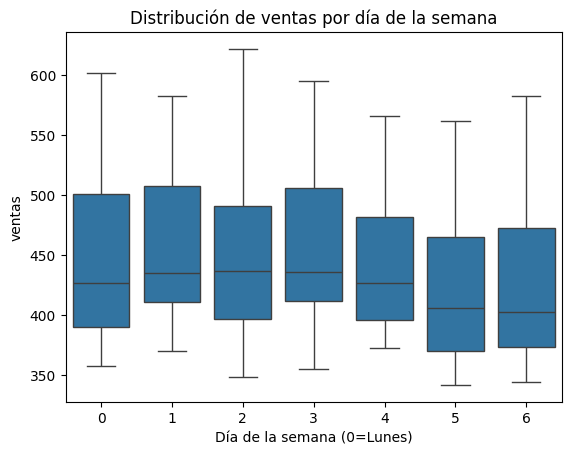

In [58]:
sns.boxplot(x=data.index.dayofweek, y=data['ventas'])
plt.title('Distribución de ventas por día de la semana')
plt.xlabel('Día de la semana (0=Lunes)')

### Comparación de densidad para diferencias de 5 a 9

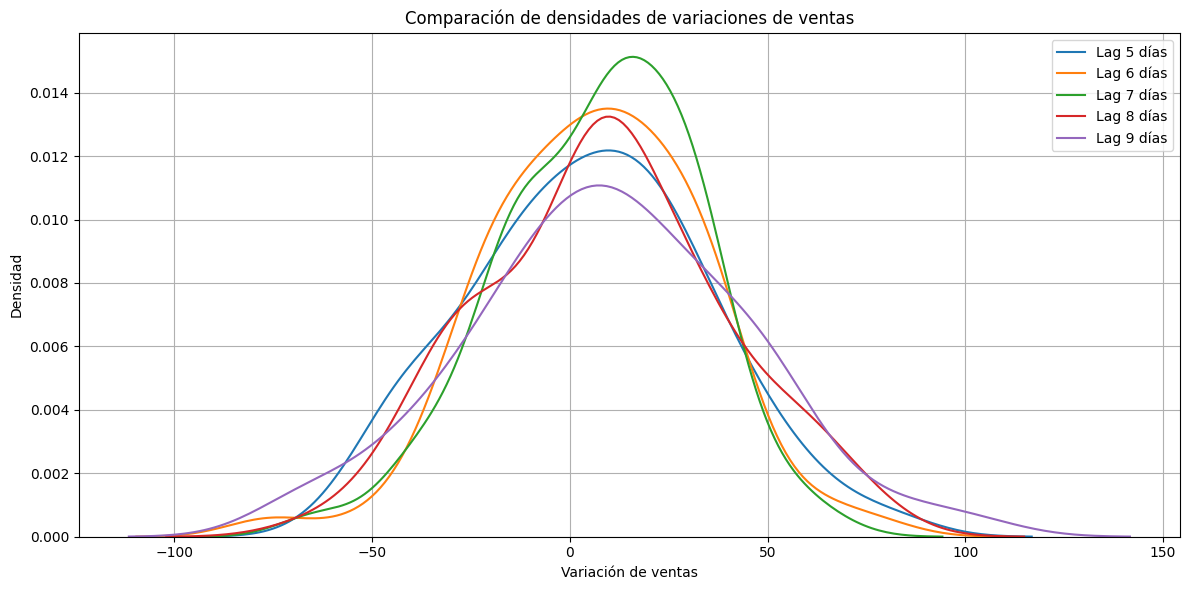

In [62]:
# Crear las diferencias con lags de 5 a 9 días
for lag in range(5, 10):
    data[f'diff_{lag}'] = data['ventas'] - data['ventas'].shift(lag)

# Graficar las densidades (KDE) de cada diferencia
plt.figure(figsize=(12, 6))

for lag in range(5, 10):
    sns.kdeplot(data[f'diff_{lag}'].dropna(), label=f'Lag {lag} días')

plt.title('Comparación de densidades de variaciones de ventas')
plt.xlabel('Variación de ventas')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Descomposición Final

Ahora que hemos comprobado que la tendencia es lineal y que existe una estacionalidad aditiva con un patrón semanal (7 periodos), procedemos a realizar la descomposición de la serie temporal. Esto nos permitirá separar y analizar de forma individual los componentes de tendencia, estacionalidad y residuo, facilitando una mejor comprensión del comportamiento subyacente de los datos.

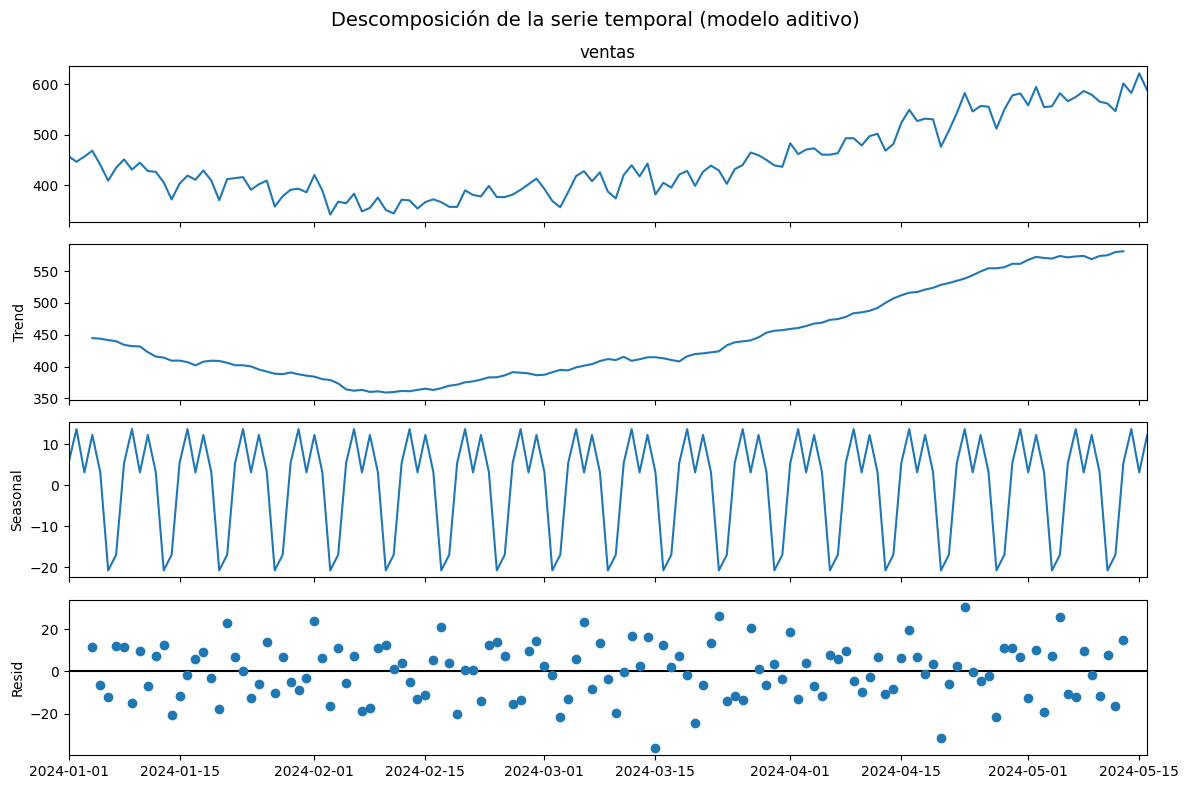

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición aditiva
descomposicion = seasonal_decompose(data['ventas'], model='additive', period=7)

# Graficar los componentes
fig = descomposicion.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Descomposición de la serie temporal (modelo aditivo)', fontsize=14)
plt.tight_layout()
plt.show()

## Modelo Holt Winters

### Ajuste

In [66]:
# Ajustar modelo Holt-Winters
modelo_hw = ExponentialSmoothing(
    data['ventas'],
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [67]:
# Predicción dentro de muestra
data['hw_fitted'] = modelo_hw.fittedvalues

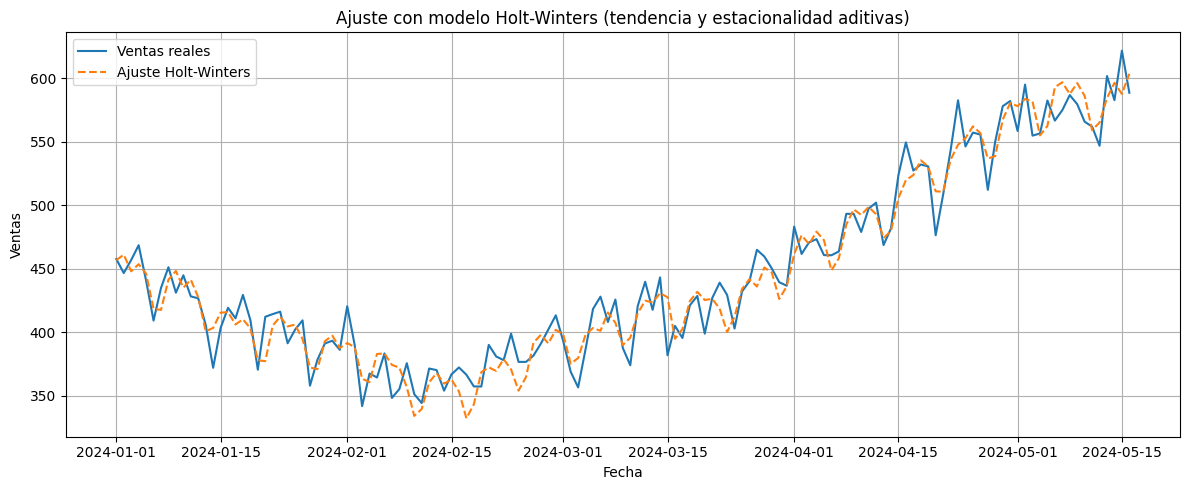

In [68]:
# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(data['ventas'], label='Ventas reales')
plt.plot(data['hw_fitted'], label='Ajuste Holt-Winters', linestyle='--')
plt.title('Ajuste con modelo Holt-Winters (tendencia y estacionalidad aditivas)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Forecast

In [72]:
forecast = modelo_hw.forecast(14)

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


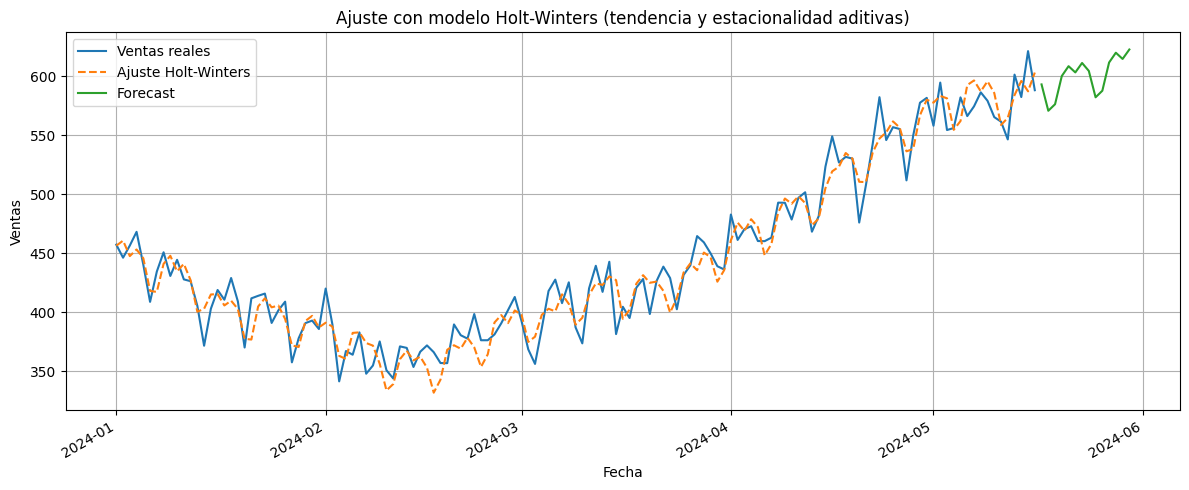

In [73]:
# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(data['ventas'], label='Ventas reales')
plt.plot(data['hw_fitted'], label='Ajuste Holt-Winters', linestyle='--')
forecast.plot(label='Forecast')
plt.title('Ajuste con modelo Holt-Winters (tendencia y estacionalidad aditivas)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluación de la Precisión

In [77]:
# Definir límites (puedes cambiarlos según lo que necesites)
fecha_inicio = pd.Timestamp('2024-01-01')
fecha_fin = pd.Timestamp('2024-06-01')
valor_min = 300
valor_max = 650

In [89]:
n_step = 14

### Tramo 1

In [90]:
# Ajustar modelo Holt-Winters
lim1 = 28
serie_1 = data['ventas'][:lim1]
test_1 = data['ventas'][:lim1+n_step][-n_step:]
modelo_hw_1 = ExponentialSmoothing(
    serie_1,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
forecast_1 = modelo_hw_1.forecast(n_step)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


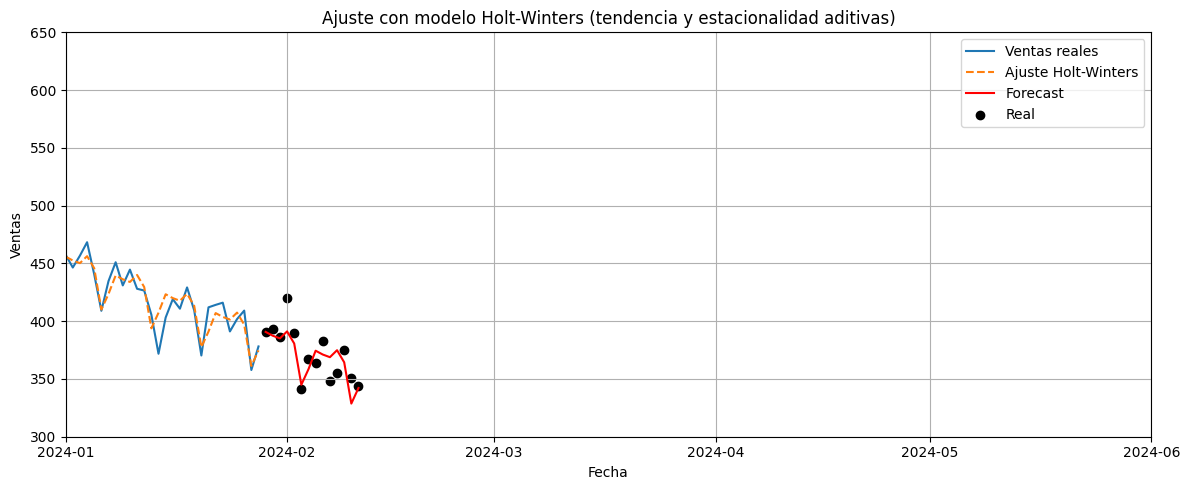

In [91]:
# Graficar con límites fijos
plt.figure(figsize=(12, 5))
plt.plot(serie_1, label='Ventas reales')
plt.plot(modelo_hw_1.fittedvalues, label='Ajuste Holt-Winters', linestyle='--')
plt.plot(forecast_1.index, forecast_1, label='Forecast', color='red')
plt.scatter(test_1.index, test_1, label='Real', color='black')

plt.title('Ajuste con modelo Holt-Winters (tendencia y estacionalidad aditivas)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xlim(fecha_inicio, fecha_fin)
plt.ylim(valor_min, valor_max)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Tramo 2

In [96]:
# Ajustar modelo Holt-Winters
lim2 = 70
serie_2 = data['ventas'][:lim2]
test_2 = data['ventas'][:lim2+n_step][-n_step:]
modelo_hw_2 = ExponentialSmoothing(
    serie_2,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
forecast_2 = modelo_hw_2.forecast(n_step)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


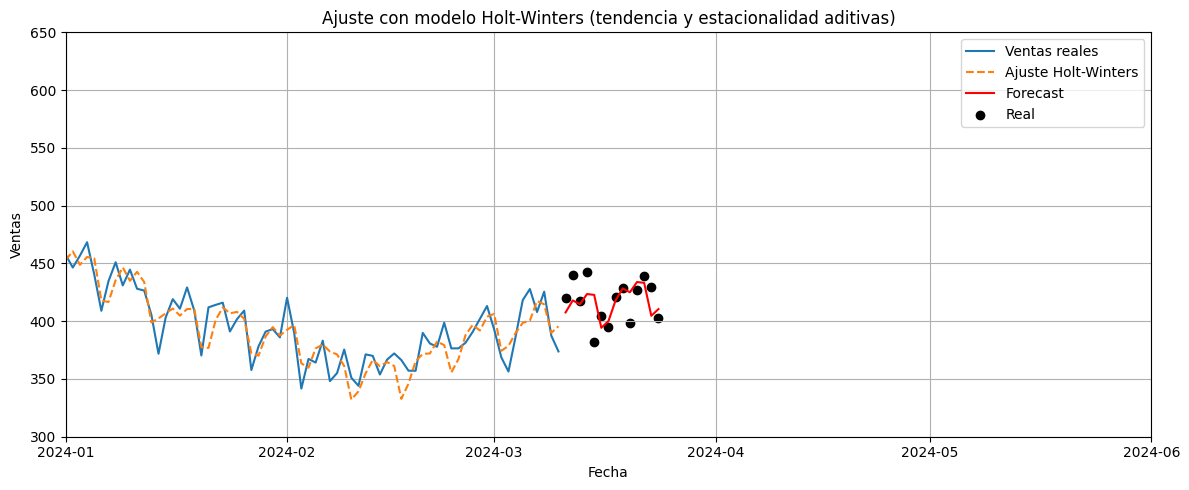

In [97]:
# Graficar con límites fijos
plt.figure(figsize=(12, 5))
plt.plot(serie_2, label='Ventas reales')
plt.plot(modelo_hw_2.fittedvalues, label='Ajuste Holt-Winters', linestyle='--')
plt.plot(forecast_2.index, forecast_2, label='Forecast', color='red')
plt.scatter(test_2.index, test_2, label='Real', color='black')

plt.title('Ajuste con modelo Holt-Winters (tendencia y estacionalidad aditivas)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xlim(fecha_inicio, fecha_fin)
plt.ylim(valor_min, valor_max)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Tramo 3

In [102]:
# Ajustar modelo Holt-Winters
lim3 = 91
serie_3 = data['ventas'][:lim3]
test_3 = data['ventas'][:lim3+n_step][-n_step:]
modelo_hw_3 = ExponentialSmoothing(
    serie_3,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
forecast_3 = modelo_hw_3.forecast(n_step)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


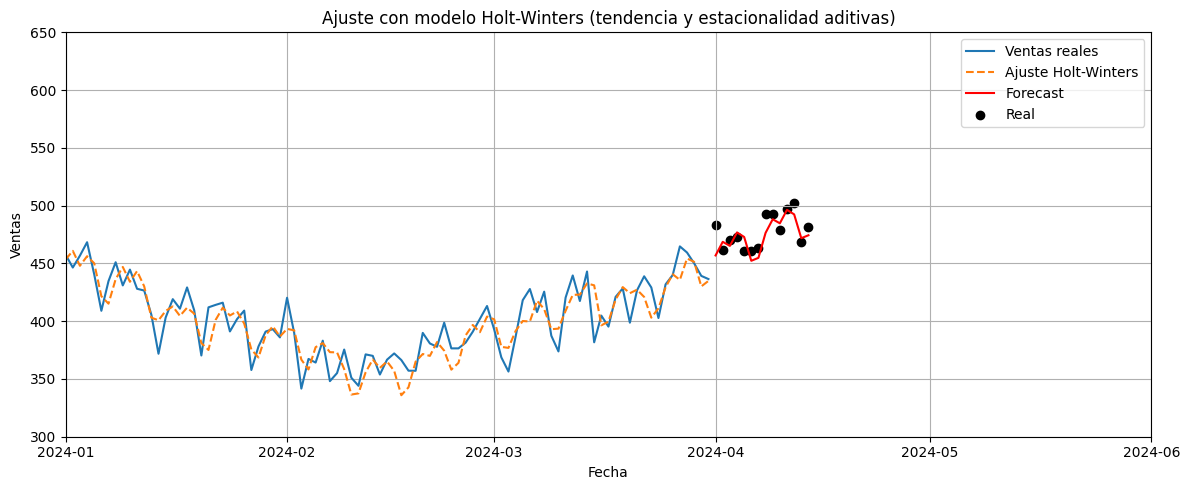

In [103]:
# Graficar con límites fijos
plt.figure(figsize=(12, 5))
plt.plot(serie_3, label='Ventas reales')
plt.plot(modelo_hw_3.fittedvalues, label='Ajuste Holt-Winters', linestyle='--')
plt.plot(forecast_3.index, forecast_3, label='Forecast', color='red')
plt.scatter(test_3.index, test_3, label='Real', color='black')

plt.title('Ajuste con modelo Holt-Winters (tendencia y estacionalidad aditivas)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xlim(fecha_inicio, fecha_fin)
plt.ylim(valor_min, valor_max)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Tramo 4

In [112]:
# Ajustar modelo Holt-Winters
lim4 = 104
serie_4 = data['ventas'][:lim4]
test_4 = data['ventas'][:lim4+n_step][-n_step:]
modelo_hw_4 = ExponentialSmoothing(
    serie_4,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
forecast_4 = modelo_hw_4.forecast(n_step)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


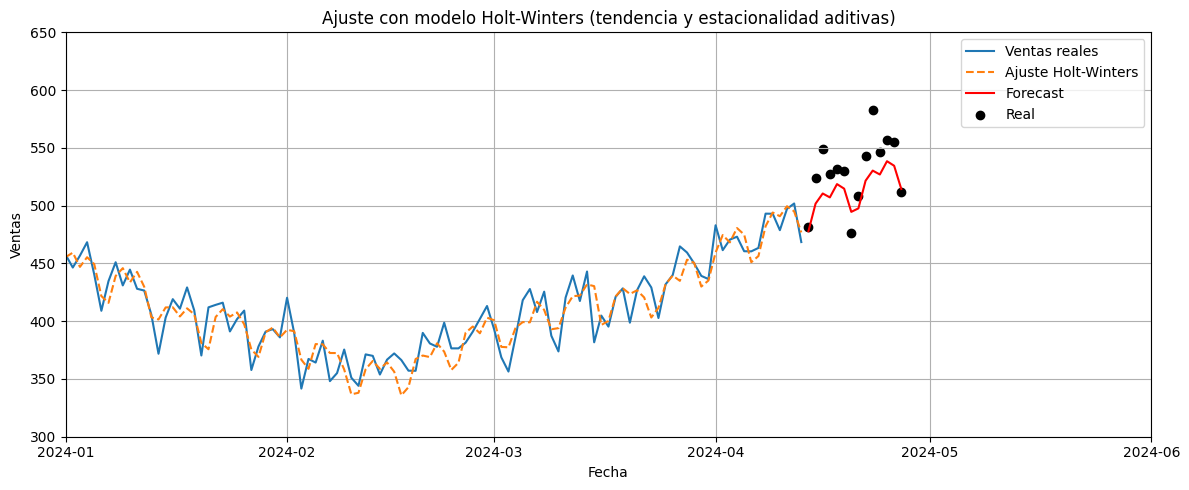

In [113]:
# Graficar con límites fijos
plt.figure(figsize=(12, 5))
plt.plot(serie_4, label='Ventas reales')
plt.plot(modelo_hw_4.fittedvalues, label='Ajuste Holt-Winters', linestyle='--')
plt.plot(forecast_4.index, forecast_4, label='Forecast', color='red')
plt.scatter(test_4.index, test_4, label='Real', color='black')

plt.title('Ajuste con modelo Holt-Winters (tendencia y estacionalidad aditivas)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xlim(fecha_inicio, fecha_fin)
plt.ylim(valor_min, valor_max)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()